# Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_forecasting-USU/blob/main/Lectures%20and%20codes/Module%207-%20Deep%20Sequence%20Modeling/Module7_Multivariate_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 7- Deep Sequence Modeling (Part 1: RNN, LSTM)

This module provides a comprehensive overview of fundamental concepts and techniques related to deep sequence modeling. Part one explores deep learning for timeseries data, highlighting the inadequacy of DNN and CNN architectures for this task and introducing the recurrent neural network (RNN) as a solution. Part two delves into deep learning for natural language processing (NLP), illustrating how neural networks can be employed to process human language. The module concludes with a practical exercise in which students apply the concepts they have learned to build a deep sequence model and perform NLP tasks using TensorFlow in Python.

This notebook has been adapted from Deep learning with Python (2nd edition). Francois Chollet
https://github.com/fchollet/deep-learning-with-python-notebooks

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow https://www.tensorflow.org/install



In [1]:
import tensorflow
tensorflow.__version__

'2.19.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## A temperature-forecasting example

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-11-12 18:39:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.186.151, 16.15.202.116, 16.15.185.89, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.186.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.60MB/s    in 2.3s    

2025-11-12 18:39:16 (5.60 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
print(lines[0:1])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30']


In [5]:
lines[0].split(",")[1:]


['996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

**Parsing the data**

In [6]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

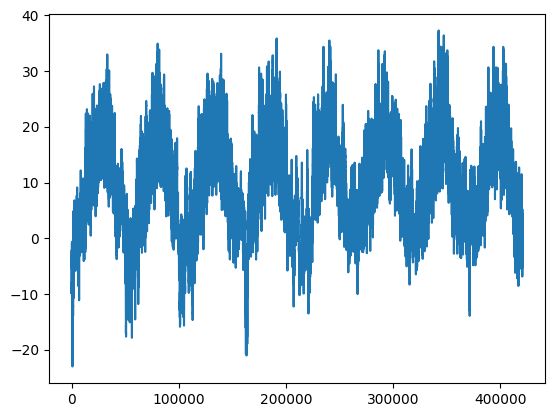

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**Plotting the first 10 days of the temperature timeseries**

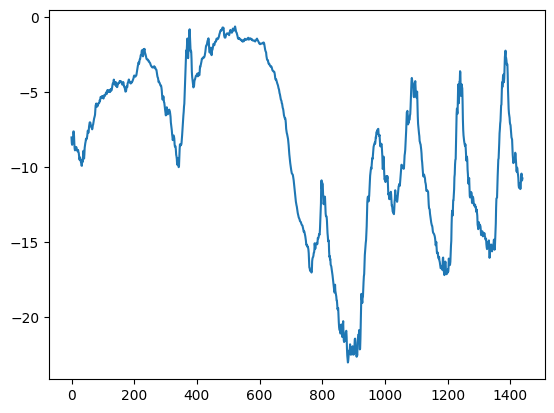

In [8]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**Computing the number of samples we'll use for each data split**

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [12]:
for inputs, targets in dummy_dataset:
  print(inputs.shape)
  print(targets.shape)
  break

(2, 3)
(2,)


**Instantiating datasets for training, validation, and testing**

In [13]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [14]:
raw_data.shape

(420451, 14)

**Inspecting the output of one of our datasets**

In [15]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [17]:
raw_data.shape[-1]

14

In [18]:
sequence_length

120

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# x = layers.Flatten()(inputs)  # This will flatten to shape (batch_size, 120*14)
# The Flatten layer was causing dimension inference issues in the newer TensorFlow version.
# Using Reshape worked because we explicitly specified the output shape as (sequence_length * raw_data.shape[-1],), avoiding any ambiguity in dimension inference.

x = layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                  save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                   epochs=10,
                   validation_data=val_dataset,
                   callbacks=callbacks)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - loss: 16.4888 - mae: 3.0961 - val_loss: 10.7007 - val_mae: 2.5790
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 9.1665 - mae: 2.3801 - val_loss: 10.3817 - val_mae: 2.5404
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 8.5133 - mae: 2.2937 - val_loss: 10.1615 - val_mae: 2.5120
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - loss: 8.0340 - mae: 2.2301 - val_loss: 12.3449 - val_mae: 2.7822
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 7.6619 - mae: 2.1774 - val_loss: 11.6629 - val_mae: 2.6885
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 56ms/step - loss: 7.4176 - mae: 2.1437 - val_loss: 11.8417 - val_mae: 2.6989
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 7.2261 - mae: 2.1162 - val_loss: 10.6323 - val_mae: 2.5662
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 56ms/step - loss: 7.0270 - mae: 2.0891 - val_loss: 12.2886 - val_mae: 2.7513
Epoch 9/10
819/819 ━━━━━━━━━━━━

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 11.2469 - mae: 2.6335
Test MAE: 2.64


In [ ]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │          26,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,828 (210.27 KB)

 Trainable params: 26,913 (105.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,915 (105.14 KB)

In [ ]:
120*14

1680

**Plotting results**

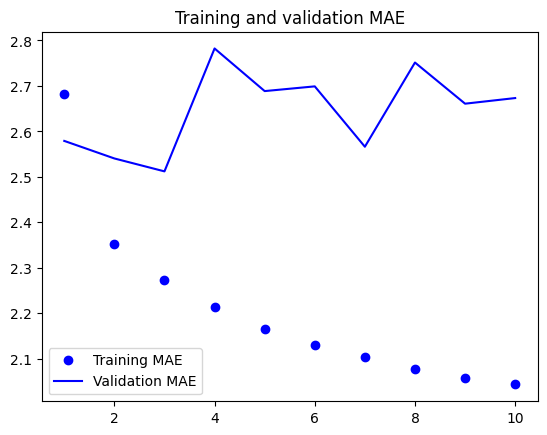

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - loss: 32.0473 - mae: 4.3340 - val_loss: 15.7827 - val_mae: 3.1038
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 86s 56ms/step - loss: 16.2265 - mae: 3.2107 - val_loss: 15.2815 - val_mae: 3.1154
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 14.6384 - mae: 3.0355 - val_loss: 14.4663 - val_mae: 2.9967
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 13.4487 - mae: 2.9048 - val_loss: 14.0916 - val_mae: 2.9614
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 59ms/step - loss: 12.6892 - mae: 2.8171 - val_loss: 13.8298 - val_mae: 2.9263
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 12.1685 - mae: 2.7621 - val_loss: 14.9905 - val_mae: 3.0383
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 11.7136 - mae: 2.7056 - val_loss: 14.0035 - val_mae: 2.9409
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 11.3780 - mae: 2.6661 - val_loss: 14.0419 - val_mae: 2.9500
Epoch 9/10
819/819 ━━━━━

In [ ]:
24*14*8+8

2696

In [ ]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 97, 8)               │           2,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 48, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 37, 8)               │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 18, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 13, 8)               │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,748 (30.27 KB)

 Trainable params: 3,873 (15.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,875 (15.14 KB)

### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - loss: 74.4324 - mae: 6.5750 - val_loss: 13.1640 - val_mae: 2.7720
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 12.5181 - mae: 2.7325 - val_loss: 9.7396 - val_mae: 2.4355
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 10.0762 - mae: 2.4741 - val_loss: 9.5853 - val_mae: 2.4077
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 53ms/step - loss: 9.5600 - mae: 2.4059 - val_loss: 9.6099 - val_mae: 2.4089
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 87s 60ms/step - loss: 9.1472 - mae: 2.3502 - val_loss: 9.4928 - val_mae: 2.3954
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - loss: 8.8274 - mae: 2.3090 - val_loss: 9.9276 - val_mae: 2.4527
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 8.6263 - mae: 2.2804 - val_loss: 9.8685 - val_mae: 2.4404
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 8.4530 - mae: 2.2572 - val_loss: 9.7061 - val_mae: 2.4226
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━

In [ ]:
4*((14*16) + (16*16) + 16 )

1984

In [ ]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,003 (7.83 KB)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 194s 234ms/step - loss: 49.5181 - mae: 5.2266 - val_loss: 9.9810 - val_mae: 2.4598
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 198s 231ms/step - loss: 15.5148 - mae: 3.0646 - val_loss: 9.2497 - val_mae: 2.3671
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 191s 233ms/step - loss: 14.6130 - mae: 2.9697 - val_loss: 9.1479 - val_mae: 2.3439
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 189s 231ms/step - loss: 14.1266 - mae: 2.9195 - val_loss: 9.0095 - val_mae: 2.3302
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 188s 229ms/step - loss: 13.6438 - mae: 2.8737 - val_loss: 8.9424 - val_mae: 2.3143
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 228ms/step - loss: 13.2867 - mae: 2.8263 - val_loss: 9.0283 - val_mae: 2.3252
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 187s 228ms/step - loss: 12.9693 - mae: 2.8001 - val_loss: 8.9800 - val_mae: 2.3155
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 200s 226ms/step - loss: 12.7269 - mae: 2.7706 - val_loss: 8.9262 - val_mae: 2.3095
Epoch 9/10
819/8

In [ ]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 34s 82ms/step - loss: 10.0820 - mae: 2.5108
Test MAE: 2.51


### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.BatchNormalization()(x)
x = layers.GRU(32, recurrent_dropout=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]


model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 464s 560ms/step - loss: 93.0509 - mae: 7.6655 - val_loss: 65.1838 - val_mae: 6.6463
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 504s 563ms/step - loss: 30.1797 - mae: 4.3401 - val_loss: 65.9884 - val_mae: 6.6866
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 459s 560ms/step - loss: 28.2562 - mae: 4.1973 - val_loss: 67.0112 - val_mae: 6.7350
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 460s 562ms/step - loss: 26.4520 - mae: 4.0729 - val_loss: 68.4267 - val_mae: 6.8014
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 459s 560ms/step - loss: 25.7945 - mae: 4.0217 - val_loss: 68.8171 - val_mae: 6.8197
405/405 ━━━━━━━━━━━━━━━━━━━━ 56s 137ms/step - loss: 65.5404 - mae: 6.6197
Test MAE: 6.64


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - loss: 56.5171 - mae: 5.5703 - val_loss: 11.2083 - val_mae: 2.6121
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 10.0478 - mae: 2.4801 - val_loss: 9.9776 - val_mae: 2.4541
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - loss: 8.7383 - mae: 2.3063 - val_loss: 10.0876 - val_mae: 2.4527
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 7.9677 - mae: 2.2005 - val_loss: 10.3877 - val_mae: 2.4980
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 7.4763 - mae: 2.1313 - val_loss: 10.1062 - val_mae: 2.4722
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 7.0730 - mae: 2.0768 - val_loss: 10.6188 - val_mae: 2.5311
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 54ms/step - loss: 6.8523 - mae: 2.0455 - val_loss: 10.7865 - val_mae: 2.5447
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 6.6005 - mae: 2.0088 - val_loss: 10.8423 - val_mae: 2.5489
Epoch 9/10
819/819 ━━━━━━━━━━━━

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 12.3259 - mae: 2.7845
Test MAE: 2.79


Done!